In [54]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy import signal

In [55]:
def euclidianDistance(oneBin, secondBin):
    return np.sum(np.square(oneBin - secondBin)), "Euclidian Distance"

def cosineDistance(oneBin, secondBin):
    return (
        1
        - np.sum(np.square(oneBin * secondBin))
        / (np.sqrt(np.sum(np.square(oneBin))) * np.sqrt(sum(np.square(secondBin)))),
        "Cosine Distance",
    )

def kullbackLeibler(oneBin, secondBin):
    return np.sum(oneBin * np.log(oneBin / secondBin)), "Kullback-Leiber"

In [56]:
def detect_Time_Signature(song, path):
#     n_fft = 2048
#     hop_length = 512
    sample, sr = librosa.load(path)
    duration = np.arange(len(sample)) / sr
    
    # win_length = sr * 0.0226  #frame length of 22.6ms
    # win_length = int(win_length)
    # hop_length = win_length//2
    
#     onset_env = librosa.onset.onset_strength(sample, sr=sr)
#     songTempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)


    tempo, beats = librosa.beat.beat_track(y=sample, sr=sr)
    beat_times = librosa.frames_to_time(beats, sr=sr)
    clicks = librosa.clicks(beat_times, sr=sr, length=len(sample))
    
    beatDurationSec = 60 / tempo
    beatDurationSample = int(beatDurationSec * sr)
    
    spectrogram, frequencies, times, im = plt.specgram(
        sample,
        Fs=sr,
        NFFT=int(beatDurationSample),
        noverlap=int(beatDurationSample / 2),
        mode="magnitude",
    )
    binsAmount = len(times)
    asm = np.zeros((binsAmount, binsAmount))

    for x in range(binsAmount):
        thisBin = spectrogram[:, x]
        for y in range(binsAmount):
            comparedBin = spectrogram[:, y]
            asm[x, y], method = euclidianDistance(thisBin, comparedBin)
            #asm[x, y], method = cosineDistance(thisBin, comparedBin)
            #asm[x, y], method = kullbackLeibler(thisBin, comparedBin)
            #asm[x, y] = asm[x, y] + np.min([asm[x-1, y-1], asm[x-1, y], asm[x, y-1]])      
  
    diagonalasNumber = len(asm)
    d = np.zeros(diagonalasNumber)
    for i in range(diagonalasNumber):
        d[i] = np.average(np.diag(asm, i))

    # %% Calculate second function d
    for i in range(diagonalasNumber):
        d[i] = -d[i] + np.max(np.abs(d))
        
    highestMeterNumerator = 6
    
    lt = int(len(asm) / highestMeterNumerator)
    t = np.zeros(highestMeterNumerator)
    for c in range(2, highestMeterNumerator, 1):
        for p in range(1, lt, 1):
            t[c] += (d[p * c]) / (1 - ((p - 1) / lt))

    t[0] = 0
    t[1] = 0

    # %% detect metre
    metre = np.argmax(t)
    return metre

In [57]:
def read_dataset():
    data = pandas.read_csv(
        "genres_tempos.csv",
        sep=",",
        names=["path", "tempo", "metre", "alt_metre","metre3", "meter4", "performer", "title"],
    )
    return data

def read_dataset_only_metre():
    data = read_dataset()
    data = data[data.metre.notnull()]
    return data

 63.56 % accuracy


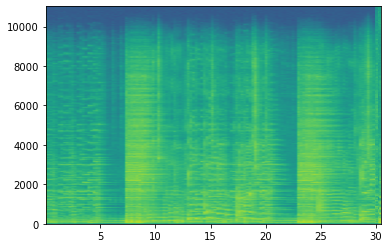

In [58]:
data = read_dataset_only_metre()
count = 0
for index, row in data.iterrows():
    song = row
    path = song.path
    path = os.path.relpath("Data/genres_original" + path)
    metre = detect_Time_Signature(song, path)
    if metre == song.metre or metre == song.alt_metre:
        count += 1

accuracy = (count / len(data)) * 100
print(f'{accuracy: .2f} % accuracy')